In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pylab as plt

from pyinverse.axis import RegularAxis
from pyinverse.grid import RegularGrid
from pyinverse.volume import volume_cal
from pyinverse.radon import radon_matrix

In [3]:
Nx = 21
Ny = 18
Na = 1
Np = 11
#Np = 40

In [4]:
axis_x = RegularAxis.linspace(-1, 1, Nx)
axis_y = RegularAxis.linspace(-1, 1, Ny)
axis_t = RegularAxis.linspace(-3, 3, Np)
#axis_theta = RegularAxis.linspace(0, 180, Na, endpoint=False)
#axis_theta = RegularAxis.linspace(90, 180, Na, endpoint=False)
#axis_theta = RegularAxis.linspace(45, 180, Na, endpoint=False)
axis_theta = RegularAxis.linspace(363, 180, Na, endpoint=False)

In [5]:
grid = RegularGrid(axis_x, axis_y)
grid_y = RegularGrid(axis_theta, axis_t)

In [6]:
def regular_grid2polytope(grid, ij):
    A = [[-1,  0],
         [ 1,  0],
         [ 0, -1],
         [ 0,  1]]
    i, j = ij
    b = [-grid.axis_y.borders[i],
          grid.axis_y.borders[i + 1],
         -grid.axis_x.borders[j],
          grid.axis_x.borders[j + 1]]
    return A, b

In [7]:
grid_y.axis_y.borders[-(2)]

2.7

In [8]:
def theta_grid2half_planes(grid_y, kl, rad=False):
    k, l = kl
    theta_k = grid_y.axis_x.centers[k]
    if not rad:
        theta_k = np.radians(theta_k)
    theta_k %= 2*np.pi
    if theta_k == 0:
        A = [[0, -1],
             [0,  1]]
        b = [-grid_y.axis_y.borders[l],
              grid_y.axis_y.borders[l+1]]
    elif theta_k == np.pi:
        A = [[0, -1],
             [0,  1]]
        b = [-grid_y.axis_y.borders[-(l+2)],
              grid_y.axis_y.borders[-(l+1)]]
    elif theta_k == np.pi/2:
        A = [[-1, 0],
             [ 1, 0]]
        b = [-grid_y.axis_y.borders[l],
              grid_y.axis_y.borders[l+1]]
    elif theta_k == 3*np.pi/2:
        A = [[-1, 0],
             [ 1, 0]]
        b = [-grid_y.axis_y.borders[-(l+2)],
              grid_y.axis_y.borders[-(l+1)]]
    else:
        c_k = np.cos(theta_k)
        s_k = np.sin(theta_k)
        y1, x1 = np.array([s_k*grid_y.axis_y.borders[l], c_k*grid_y.axis_y.borders[l]])
        y2, x2 = np.array([s_k*grid_y.axis_y.borders[l+1], c_k*grid_y.axis_y.borders[l+1]])
        A = np.array([[-s_k, -c_k],
                      [ s_k,  c_k]])
        b = np.array([-y1*s_k - x1*c_k,
                       y2*s_k + x2*c_k])
    return A, b

In [9]:
A_radon = radon_matrix(grid, grid_y, a=1/grid_y.axis_y.T)

100%|███████████████████████████████████████████████████████████| 378/378 [00:00<00:00, 1143.42it/s]


In [10]:
grid_y.shape

(11, 1)

In [11]:
A_polytope = np.empty((np.prod(grid_y.shape), np.prod(grid.shape)))
for l in range(Np):
    for k in range(Na):
        A_t, b_t = theta_grid2half_planes(grid_y, (k, l), rad=False)
        for i in range(Ny):
            for j in range(Nx):
                A_grid, b_grid = regular_grid2polytope(grid, (i, j))
                A_lass = np.vstack((A_grid, A_t))
                b_lass = np.hstack((b_grid, b_t))
                A_polytope[l*Na+k, i*Nx+j] = volume_cal(6, 2, A_lass, b_lass) / grid_y.axis_y.T

<IPython.core.display.Javascript object>


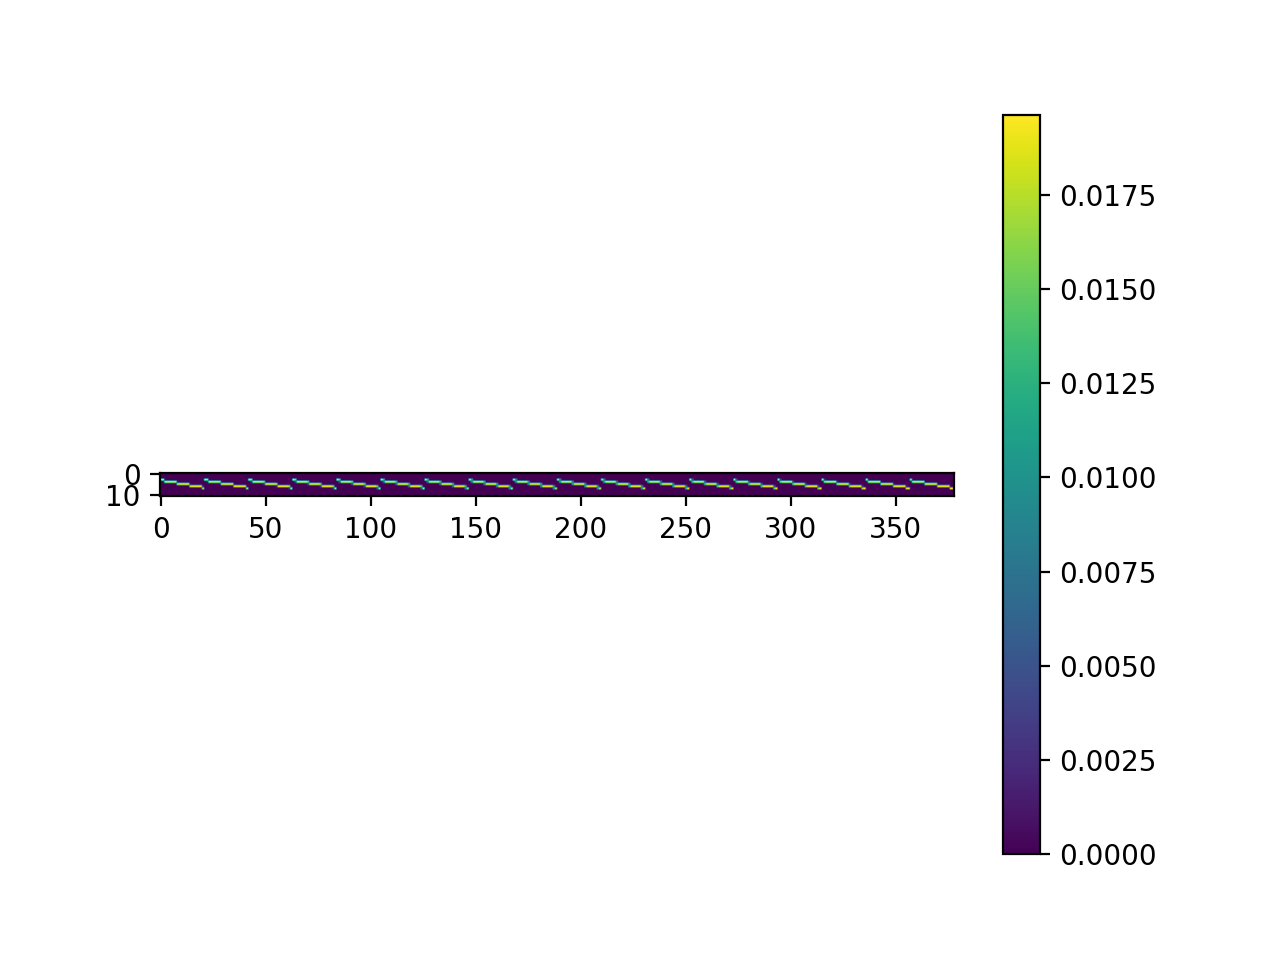

In [12]:
fig, ax = plt.subplots()
im = ax.imshow(A_radon.todense())
fig.colorbar(im)

<IPython.core.display.Javascript object>


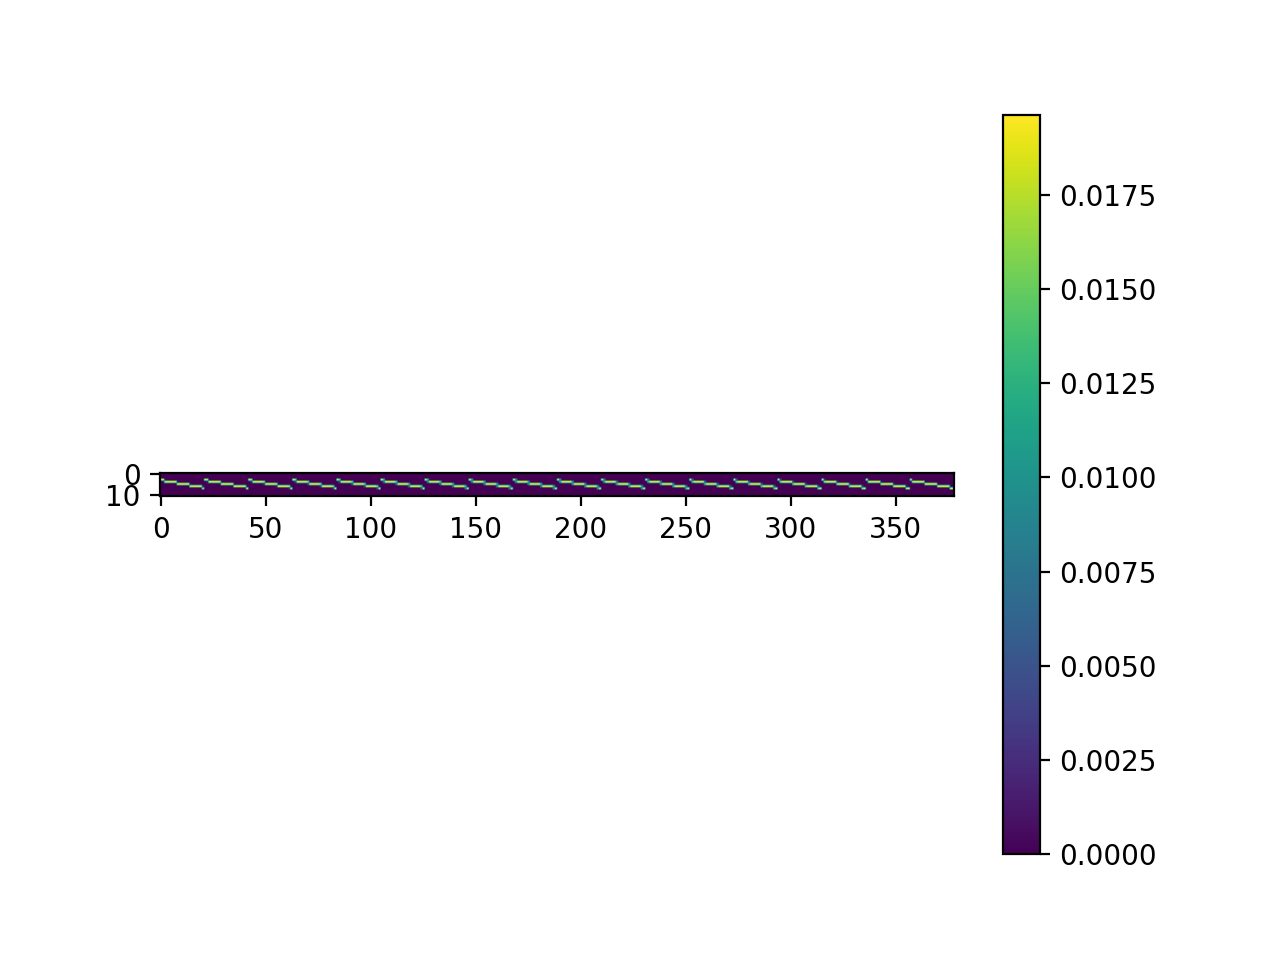

In [13]:
fig, ax = plt.subplots()
im = ax.imshow(A_polytope)
fig.colorbar(im)

In [14]:
assert np.allclose(A_radon.todense(), A_polytope)

<IPython.core.display.Javascript object>


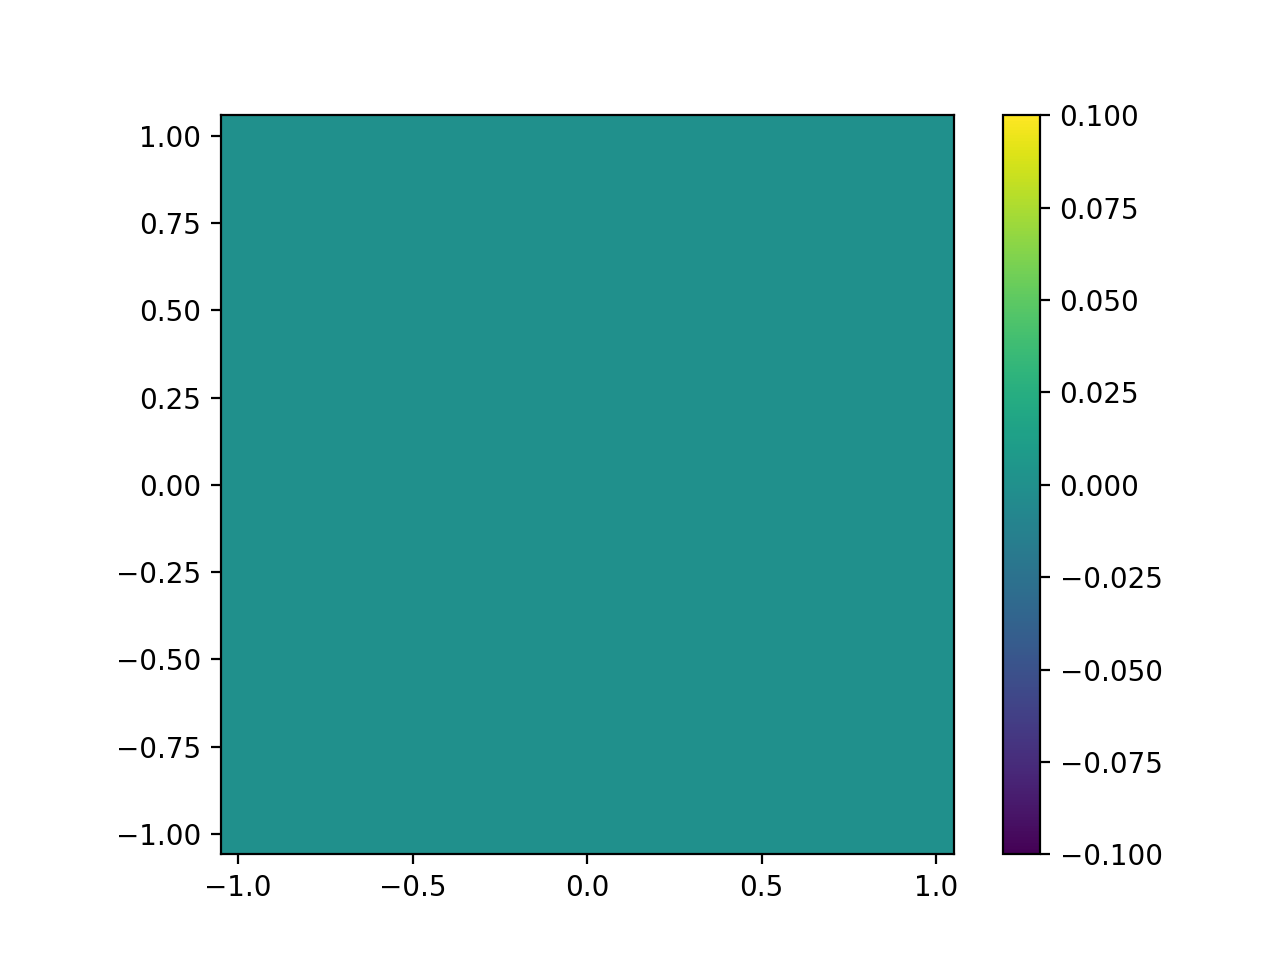

In [15]:
fig, ax = plt.subplots()
im = grid.plot(ax, A_radon.todense()[1, :].reshape((Ny, Nx)))
fig.colorbar(im)

<IPython.core.display.Javascript object>


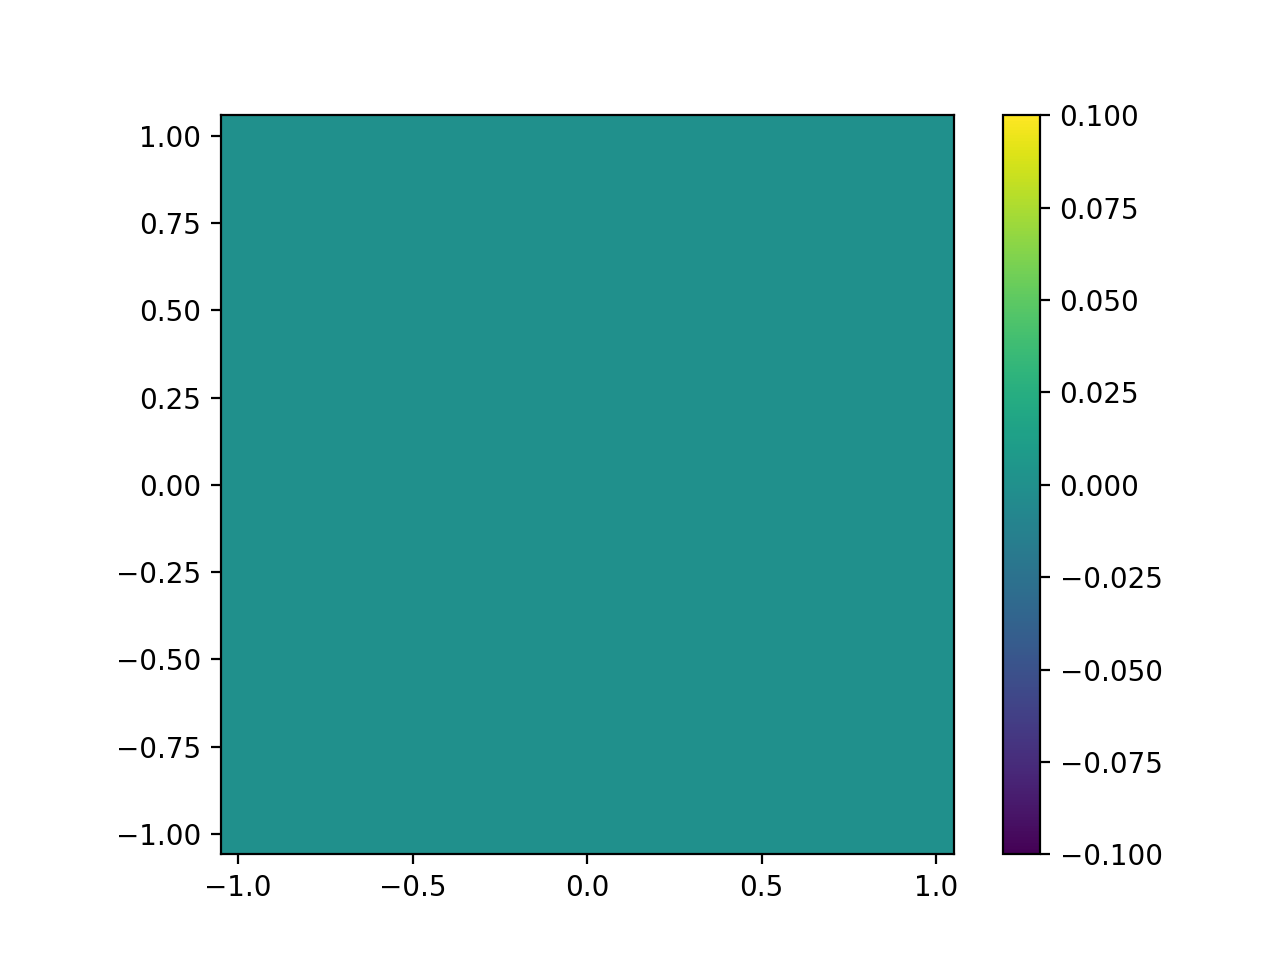

In [16]:
fig, ax = plt.subplots()
im = grid.plot(ax, A_polytope[1, :].reshape((Ny, Nx)))
fig.colorbar(im)

In [17]:
A_grid, b_grid = regular_grid2polytope(grid, (0, 0))

In [18]:
I_grid = RegularGrid.linspace((grid.axis_x.centers[0], grid.axis_x.centers[-1], 200), 
                              (grid.axis_y.centers[0], grid.axis_y.centers[-1], 200))

In [19]:
I = np.array([all(np.array(A_grid) @ np.array(x) <= b_grid) for x in zip(I_grid.centers[1].flat, I_grid.centers[0].flat)])
I.shape = I_grid.shape

<IPython.core.display.Javascript object>


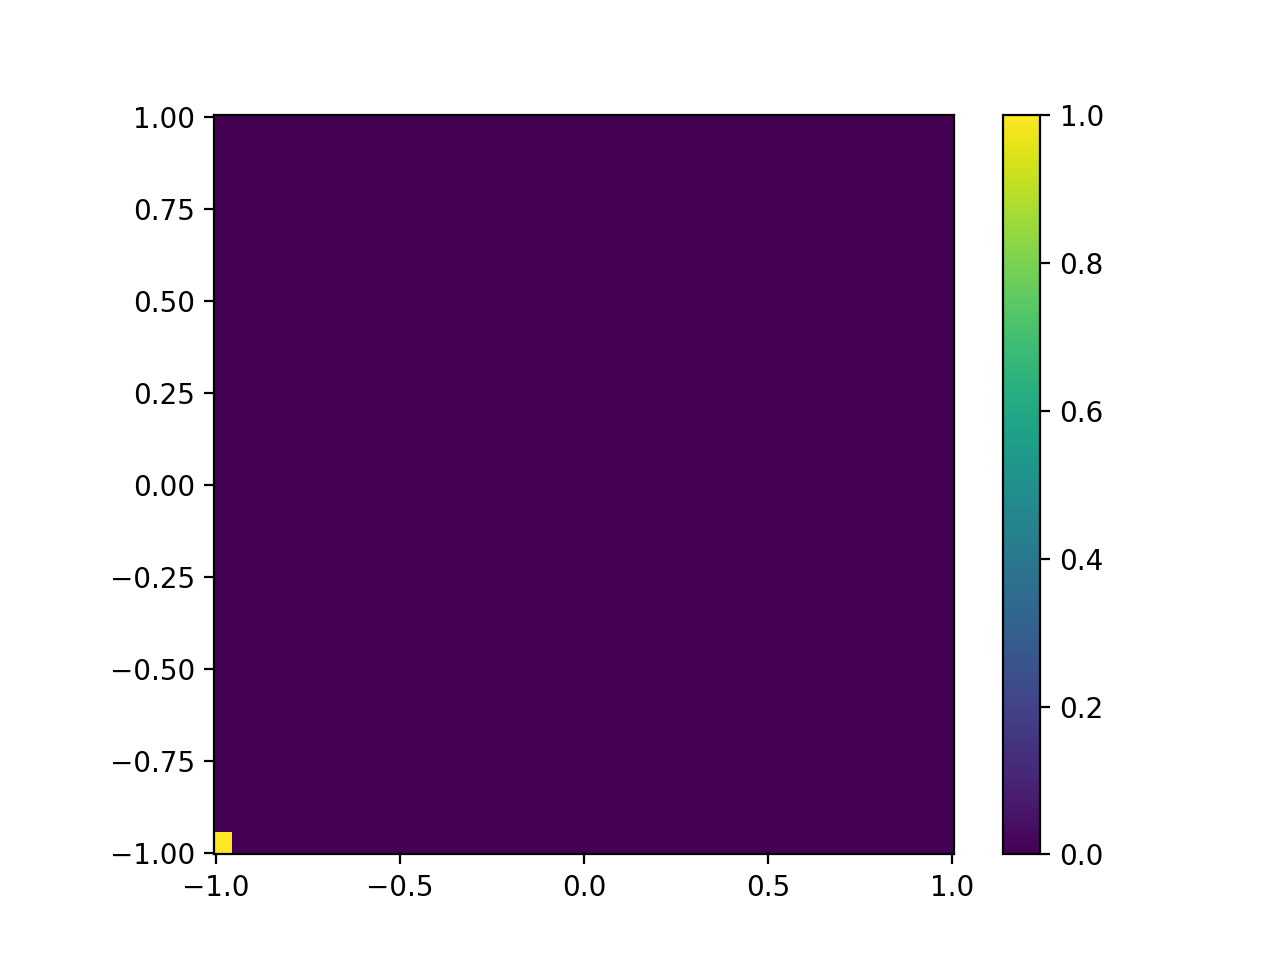

In [20]:
fig, ax = plt.subplots()
im = I_grid.plot(ax, I)
fig.colorbar(im)

In [21]:
A_hp, b_hp = theta_grid2half_planes(grid_y, (0, 2), rad=False)
A_hp, b_hp

(array([[-0.05233596, -0.99862953],
        [ 0.05233596,  0.99862953]]),
 array([ 2.1, -1.5]))

In [22]:
grid_y.axis_y.borders

array([-3.3, -2.7, -2.1, -1.5, -0.9, -0.3,  0.3,  0.9,  1.5,  2.1,  2.7,
        3.3])

In [23]:
I_hp = np.array([all(np.array(A_hp) @ np.array(x) <= b_hp) for x in zip(I_grid.centers[1].flat, I_grid.centers[0].flat)])
I_hp.shape = I_grid.shape

<IPython.core.display.Javascript object>


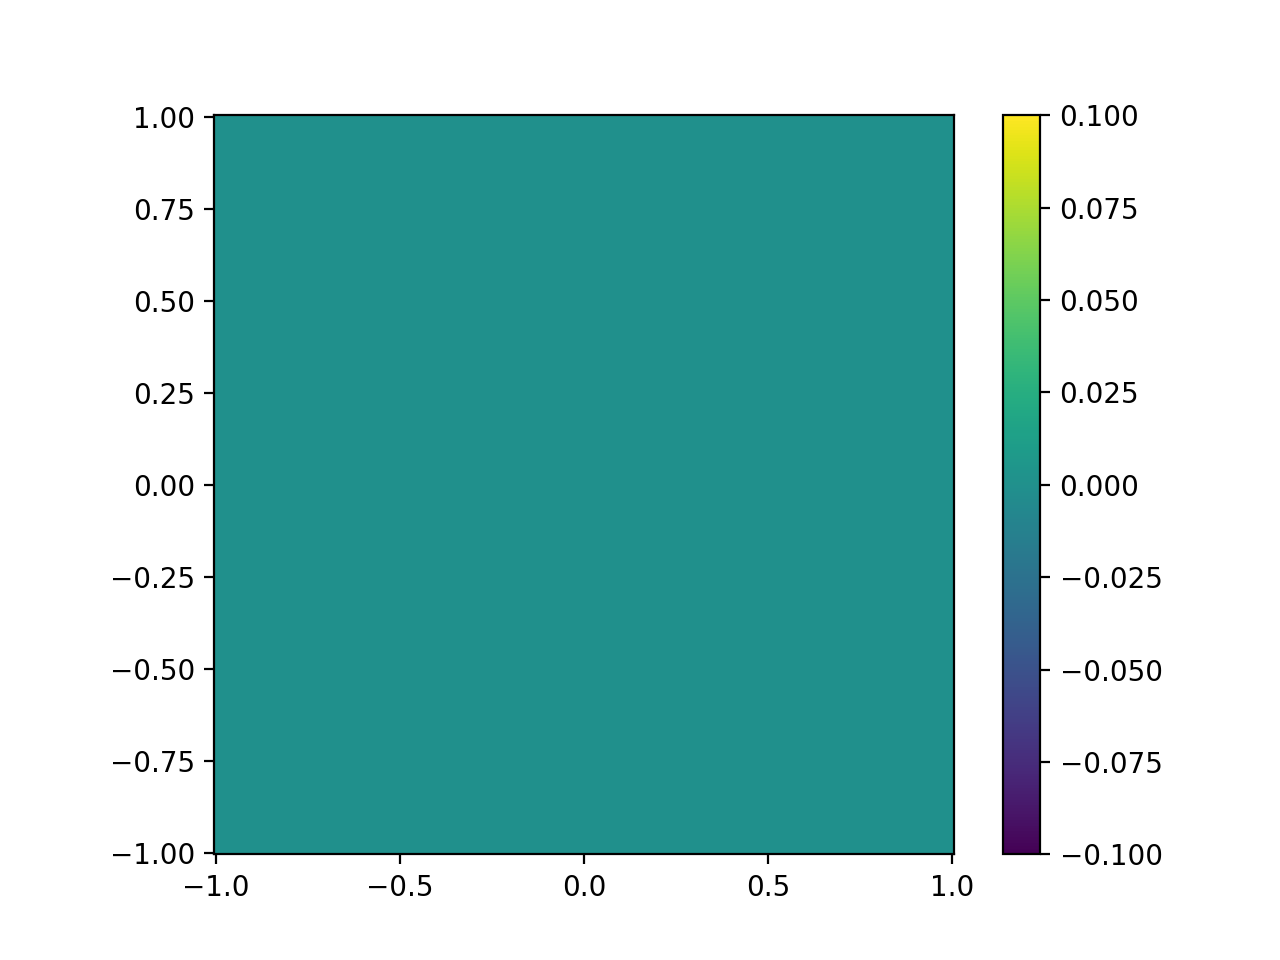

In [24]:
fig, ax = plt.subplots()
im = I_grid.plot(ax, I_hp)
fig.colorbar(im)

In [25]:
def plot_rect_ij(ax, grid, ij, **kwds):
    i, j = ij
    ax.hlines(grid.axis_y.borders[i:i+2], grid.axis_x.borders[j], grid.axis_x.borders[j+1], **kwds)
    ax.vlines(grid.axis_x.borders[j:j+2], grid.axis_y.borders[i], grid.axis_y.borders[i+1], **kwds)
    return ax

In [26]:
def plot_hp_kl(ax, grid_y, kl, bounds=3, rad=False, **kwds):
    k, l = kl
    
    theta_k = grid_y.axis_x[k]
    if not rad:
        theta_k = np.radians(theta_k)
        
    if np.allclose(theta_k, 0):
        ax.vlines(grid_y.axis_y[l:l+2], -bounds, bounds, **kwds)
        #ax.fill_between(grid_y.axis_y[l:l+2], -bounds, bounds, **kwds)
    elif np.allclose(theta_k, np.pi/2):
        ax.hlines(grid_y.axis_y[l:l+2], -bounds, bounds, **kwds)
    else:        
        c_k = np.cos(theta_k)
        s_k = np.sin(theta_k)
        
        y1, x1 = np.array([s_k*grid_y.axis_y.borders[l], c_k*grid_y.axis_y.borders[l]])
        y2, x2 = np.array([s_k*grid_y.axis_y.borders[l+1], c_k*grid_y.axis_y.borders[l+1]])
        
        t_k = np.tan(theta_k)
        m = -1/t_k
        
        x_left1 = (bounds-y1)/m + x1
        if x_left1 < -bounds:
            x_left1 = -bounds
        elif x_left1 > bounds:
            x_left1 = bounds
        y_left1 = m*(x_left1 - x1) + y1
        
        x_right1 = (-bounds-y1)/m + x1
        if x_right1 < -bounds:
            x_right1 = -bounds
        elif x_right1 > bounds:
            x_right1 = bounds
        y_right1 = m*(x_right1 - x1) + y1
        
        ax.plot([x_left1, x_right1], [y_left1, y_right1], **kwds)
        
        x_left2 = (bounds-y2)/m + x2
        if x_left2 < -bounds:
            x_left2 = -bounds
        elif x_left2 > bounds:
            x_left2 = bounds
        y_left2 = m*(x_left2 - x2) + y2
        
        x_right2 = (-bounds-y2)/m + x2
        if x_right2 < -bounds:
            x_right2 = -bounds
        elif x_right2 > bounds:
            x_right1 = bounds
        y_right2 = m*(x_right2 - x2) + y2
        
        ax.plot([x_left2, x_right2], [y_left2, y_right2], **kwds)
        
        return ax

<IPython.core.display.Javascript object>


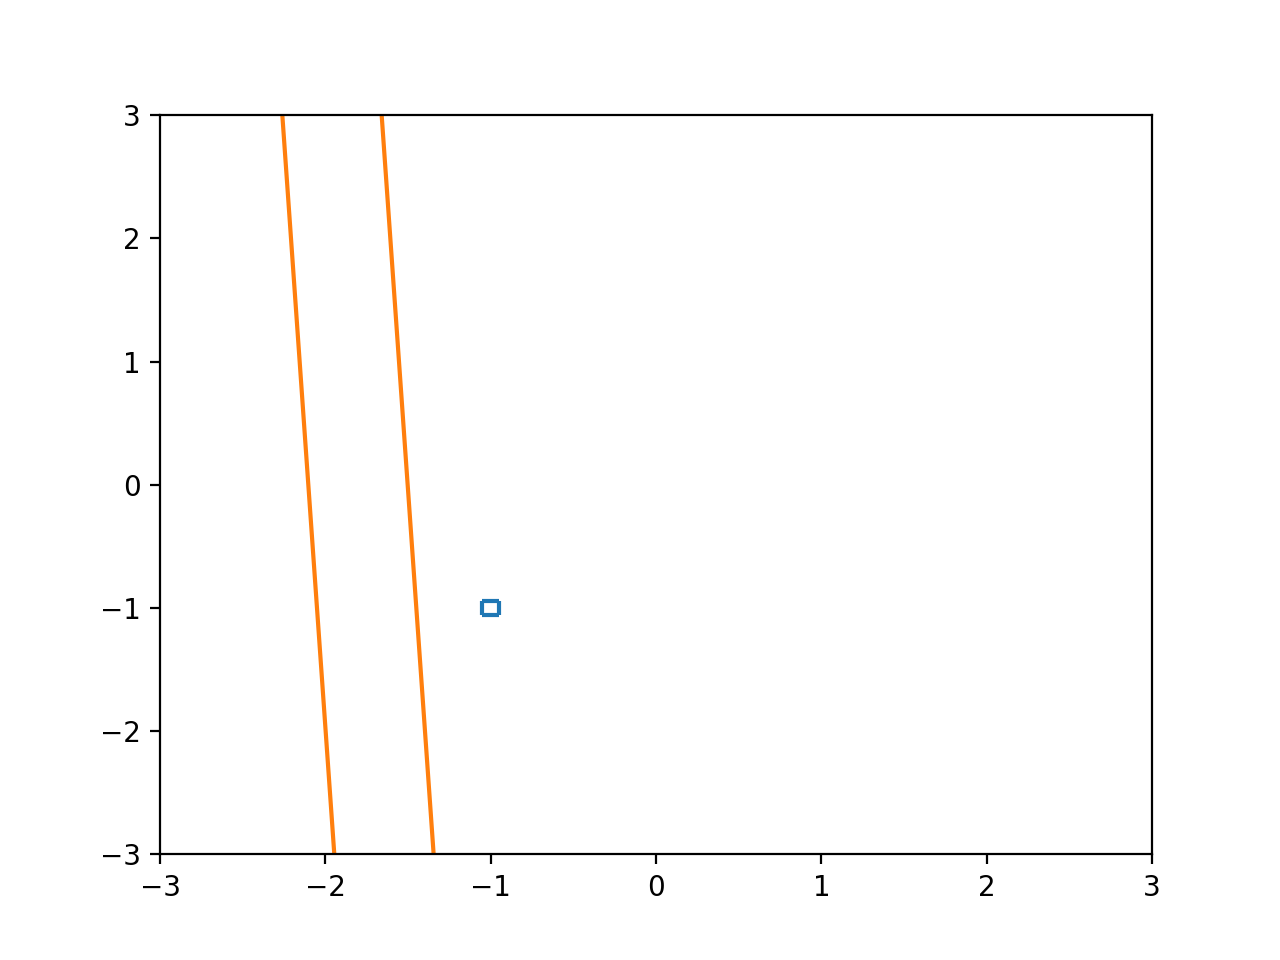

(-3.0, 3.0, -3.0, 3.0)

In [27]:
fig, ax = plt.subplots()
plot_rect_ij(ax, grid, (0, 0))
plot_hp_kl(ax, grid_y, (0, 2), color='C1')
#ax.axis('equal')
#ax.axis([-1.1, 1.1, -1.1, 1.1])
#ax.axis([-1, 1, -1, 1])
ax.axis([-3, 3, -3, 3])